# Experimenting with least squares and its variants

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn import datasets
from scipy.optimize import fmin_bfgs
import numpy as np
from numpy.linalg import norm
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression

## Data preparation

In [2]:
boston = datasets.load_boston()
data = np.array(boston.data)

The boston dataset is one of the standard regression problems used to experiment with learning algorithms. Below you can find the dataset description

In [3]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

First step to apply the formulae we learnt during the lectures is to rewrite the dataset in homogeneous coordinates (i.e., we append a column of 1 to the matrix containing the examples):

In [4]:
boston = datasets.load_boston()
data = np.array(boston.data)
t = np.ones(len(data)).reshape(len(data),1) # inseriamo una colonna di 1
data = np.append(data, t, 1)
target = np.array(boston.target)

We now divide the data into a training set $X$ and a test set $X_\textrm{test}$.

In [5]:
X, y = data[0:400,:], target[0:400]
X_test, y_test = data[400:,:], target[400:]

# Exercise

1. Calculate the least square solution (to the regression problem outlined above) and evaluate its performances on the training set and on the test set.
1. Calculate the ridge regression solution (set lambda to 0.01) and evaluate its performances on the training set and on test set.
1. Calculate the lasso regression solution and evaluate its performances on the training set and on the test set.

## Notes

- Here it follows a list of functions you may want to use (the required packages are already imported at the beginning of this notebook) along with a very brief explanation of their purpose (`help(nomefun)` will provide you more information about function `nomefun`):
    - `transpose`: matrix transposition (e.g., `transpose(X)`)
    - `dot`: matrix multiplication (e.g., `X.dot(X2)`) 
    - `inv`: matrix inversion (e.g., `inv(X)`)
- to solve the lasso problem you will need to perform a numerical minimization of the associated loss function (as you know, a closed form solution does not exist). There are many numerical optimization algorithms available in the scipy package. My suggestion is to use `fmin_bfgs`. Here it follows an example of how to use it:
    ```python
        def f(w):
            return w[0]**2 + w[1]**2 + w[0] + w[1]
        
        w = fmin_bfgs(f, [0,0])
    ```
    note that the function may (and should) reference your data variables (i.e., $X$ and $y$).
- to evaluate the performances of your solutions use the $S$ statistic:
    $$
        S =  \sqrt{ \frac{1}{n} \sum_{i=1}^n (y_i' - y_i)^2 }
    $$
    where $y'_i$ is your model prediction for the i-th example, and $n$ is the number of examples.

In [6]:
def least_squares(X,y):
    """
    X: matrice con le colonne che corrispondono alle feature (e un esempio per riga)
    y: vettore dei target value
    return: vettore di grandezza num-feature +1 (rappresenta i coefficienti dell'iperpiano)
    """
    XTX_inv = inv(np.dot(X.T,X)) # (X^TX)^-1
    XTX_inv_dot_XT = np.dot(XTX_inv, X.T) # (X^TX)^-1 * X^T
    return np.dot(XTX_inv_dot_XT, y) # w = (X^TX)^-1 * X^T * y

In [7]:
def s_statistic(actual, predicted):
    """
    actual: valori reali
    predicted: valori predetti
    return: risultato della S statistic
    """
    return np.sqrt(((predicted - actual) ** 2).mean())

### Esempio

In [8]:
def add_colum_of_one(x):
    t = np.ones((len(x), 1)) # matrice len(x) * 1
    return np.hstack((x, t)) # concatenazione su axis=1 (colonne)

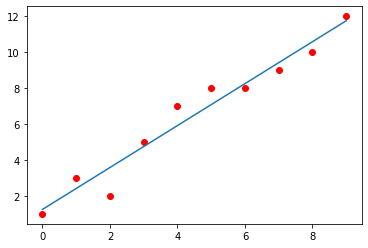

In [9]:
x_toy = np.array([[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]) 
x_one = add_colum_of_one(x_toy)
y_toy = np.array([1, 3, 2, 5, 7, 8, 8, 9, 10, 12]) 

w = least_squares(x_one, y_toy) # len(w), size w = numero di coefficienti (num feature + 1)
y_pred = w[0] * x_toy + w[1]

plt.scatter(x_toy, y_toy, c='r')
plt.plot(x_toy, y_pred)
plt.show()

In [10]:
print("S statistic:\t", s_statistic(y, y_pred))

S statistic:	 20.326435392305648


### Least squares

In [11]:
# Calcolo dei pesi w
w = least_squares(X, y)

# Predizione di training e test set
y_train_pred = np.dot(X, w)
y_test_pred = np.dot(X_test, w)

In [12]:
# Creazione linear regressor (sklearn)
lr = LinearRegression().fit(X,y)

# Predizione su training e test set del linear regressor
y_train_lr = lr.predict(X)
y_test_lr = lr.predict(X_test)

##### Confronto LineaRegression e LeastSquares implementato

In [13]:
print("Least squares\n")
print("Set \t\t S statistic")
print("-" * 30)
print("Training \t {}\n".format(s_statistic(y, y_train_pred)))
print("Test \t\t {}\n".format(s_statistic(y_test, y_test_pred)))

print("_" * 110)

print("\nLinear Regression\n")
print("Set \t\t S statistic")
print("-" * 30)
print("Training \t {}\n".format(s_statistic(y, y_train_lr)))
print("Test \t\t {}\n".format(s_statistic(y_test, y_test_lr)))

Least squares

Set 		 S statistic
------------------------------
Training 	 4.722840838326382

Test 		 6.1557922804127925

______________________________________________________________________________________________________________

Linear Regression

Set 		 S statistic
------------------------------
Training 	 4.722840838326382

Test 		 6.155792280413755



### Ridge regression

In [14]:
def ridge_regression(X, y, l=0.01):
    """
    X: matrice con le colonne che corrispondono alle feature (e un esempio per riga)
    y: vettore dei target value
    return: vettore di grandezza num-feature +1 (rappresenta i coefficienti dell'iperpiano)
    """
    XTX = np.dot(X.T, X) # X^TX
    lambdaI = np.eye(XTX.shape[0]) * l # lambdaI
    XTX_lambdaI_inv = inv(XTX + lambdaI) # (X^TX + lambdaI)^-1
    return XTX_lambdaI_inv.dot(X.T).dot(y) # (X^TX + lambdaI)^-1 * X^T * y

In [15]:
w = ridge_regression(X, y) # len(w) = 14 (num feature + 1)

y_train_pred = np.dot(X, w)
y_test_pred = np.dot(X_test, w)

In [16]:
print("\nRidge Regression\n")
print("Set \t\t S statistic")
print("-" * 30)
print("Training \t {}\n".format(s_statistic(y, y_train_pred)))
print("Test \t\t {}\n".format(s_statistic(y_test, y_test_pred)))


Ridge Regression

Set 		 S statistic
------------------------------
Training 	 4.722895265098321

Test 		 6.141787930902393



### Lasso regression

In [17]:
def lasso_regression(w, X, y, l):
    """
    w: pesi che devono essere minimizzati. dimensione(num_features+1)
    X: dimensione(num_esempi, num_features+1)
    y: dimensione(num_esempi)
    l: valore lambda (0.01)
    """
    yXw = (y - X.dot(w)) # (y - Xw)
    return yXw.T.dot(yXw) + l * norm(w,1) # (y - Xw)^T (y - Xw) + lambda||w||

In [18]:
init_guess = np.zeros((X.shape[1])) # 14 feature

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html
w = fmin_bfgs(lasso_regression, init_guess, args=(X, y, 0.01))

y_train_pred = np.dot(X, w)
y_test_pred = np.dot(X_test, w)

         Current function value: 8922.627021
         Iterations: 19
         Function evaluations: 817
         Gradient evaluations: 51


In [19]:
print("\nLasso Regression\n")
print("Set \t\t S statistic")
print("-" * 30)
print("Training \t {}\n".format(s_statistic(y, y_train_pred)))
print("Test \t\t {}\n".format(s_statistic(y_test, y_test_pred)))


Lasso Regression

Set 		 S statistic
------------------------------
Training 	 4.722840863745931

Test 		 6.1555556765721455

